# Домашнее задание:
1) взять данные отсюда: https://github.com/Laggg/data--for--students (flight_delays.csv)

Задача: научиться предсказывать задержку (столбик *dep_delayed_15min*) рейса по имеющимся данным с помощью Дерева решений (или других алгоритмов).
Это задача бинарной классификации (будет/не будет задержка). Улучшить приведенный пример.

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')


import itertools
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

def plot_confusion_matrix(targets,predictions,classes,
                          normalize=False,title='Confusion matrix',
                          figsize=(4, 4), cmap=plt.cm.Reds):

    conf_matrix = confusion_matrix(y_true=targets, y_pred=predictions)

    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title.lower()

    plt.figure(figsize=figsize)
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):

        if normalize:
            value = '{} %'.format(format(conf_matrix[i, j] * 100, '.2f'))
        else:
            value = format(conf_matrix[i, j], fmt)

        plt.text(j,i,value,horizontalalignment="center",color="white" if conf_matrix[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()

In [2]:
path_to_file = 'flight_delays.csv'
data = pd.read_csv(path_to_file)
data.head(10)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
5,c-8,c-3,c-4,1918,NW,MEM,MCO,683,N
6,c-1,c-27,c-4,754,DL,PBI,LGA,1035,N
7,c-4,c-29,c-6,635,OH,MSP,CVG,596,N
8,c-7,c-28,c-5,735,AA,ONT,DFW,1189,N
9,c-6,c-20,c-2,2029,OO,DEN,PSC,853,N


In [3]:
# Отделим столбик-таргет от признаков:
target = (data['dep_delayed_15min'] == 'Y').astype(int)

data = data.drop(['dep_delayed_15min'], axis=1)
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732
1,c-4,c-20,c-3,1548,US,PIT,MCO,834
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423


In [33]:
# возьмем несколько столбцов данных как признаки, по которым будем предсказывать:
X = data[['DepTime','Distance', 'Month']]
X['DepTime'] = X['DepTime']//100
X.loc[X['DepTime'] == 24, 'DepTime'] = 0
X.loc[X['DepTime'] == 25, 'DepTime'] = 1
X['Month'] = X['Month'].apply(lambda x: int(x[2:]))
X.head()

,DepTime,Distance,Month
0,19,732,8
1,15,834,4
2,14,416,9
3,10,872,11
4,18,423,10


In [10]:
# разделим выборку на обучающую и тестовую(валидационную, проверочную, отложенная)
x_train, x_test, y_train, y_test = train_test_split(X, target, test_size=0.1, random_state=42)

# обучим модель дерева на обучающей выборке и предскажем на отложенной:
model = DecisionTreeClassifier(max_depth=40, min_samples_split=2)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

Общее число совпадений 0.7467
Полнота охвата класса 1: 0.23064935064935066
Точность: 0.2967914438502674


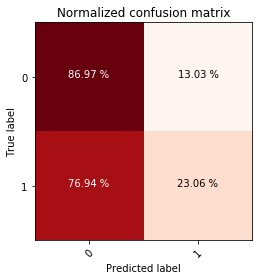

In [11]:
# матрица ошибок алгоритма. При хорошем прогнозе на главной диагонали будут стоять цифры, близкие к 100.
print('Общее число совпадений', accuracy_score(y_test, y_pred))
print('Полнота охвата класса 1:', recall_score(y_test, y_pred))
print('Точность:', precision_score(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, [0,1], normalize=True)

### Попробуем улучшить модель

Преобразуем категориальные признаки с помощью OneHotEncoder

In [13]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [69]:
X = data[['DepTime','Distance', 'Month', 'Dest', 'UniqueCarrier', 'Origin']]
X['DepTime'] = X['DepTime']//100
X.loc[X['DepTime'] == 24, 'DepTime'] = 0
X.loc[X['DepTime'] == 25, 'DepTime'] = 1
X['Month'] = X['Month'].apply(lambda x: int(x[2:]))
X.head()

,DepTime,Distance,Month,Dest,UniqueCarrier,Origin
0,19,732,8,DFW,AA,ATL
1,15,834,4,MCO,US,PIT
2,14,416,9,CLE,XE,RDU
3,10,872,11,MEM,OO,DEN
4,18,423,10,OMA,WN,MDW


In [70]:
categ = X[['DepTime', 'Month', 'Dest', 'UniqueCarrier', 'Origin']]
num = np.array(X['Distance'])
categ_1 = OneHotEncoder().fit_transform(categ).toarray()
X_1 = np.hstack([categ_1, num.reshape(-1,1)])

In [71]:
x_train, x_test, y_train, y_test = train_test_split(X_1, target, test_size=0.1, random_state=42)

Подберём параметры модели

In [75]:
params = {
    'max_depth': np.arange(80, 150, 10),
    'min_samples_split': np.arange(2, 12, 2)
}
model_1 = GridSearchCV(DecisionTreeClassifier(),
                       param_grid = params, 
                       scoring='f1',
                       cv=3,
                       n_jobs=-1
                      )
model_1.fit(x_train, y_train)
y_pred_1 = model_1.predict(x_test)

Общее число совпадений 0.766
Полнота охвата класса 1: 0.30493506493506495
Точность: 0.3694147262429201


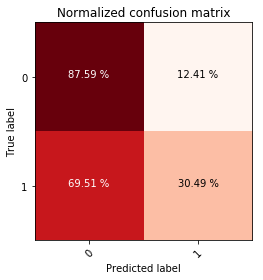

In [76]:
print('Общее число совпадений', accuracy_score(y_test, y_pred_1))
print('Полнота охвата класса 1:', recall_score(y_test, y_pred_1))
print('Точность:', precision_score(y_test, y_pred_1))
plot_confusion_matrix(y_test, y_pred_1, [0,1], normalize=True)

In [84]:
categ_2 = np.vstack([LabelEncoder().fit_transform(categ.iloc[:, 0]),
                     LabelEncoder().fit_transform(categ.iloc[:, 1]),
                    LabelEncoder().fit_transform(categ.iloc[:, 2]),
                    LabelEncoder().fit_transform(categ.iloc[:, 3]),
                    LabelEncoder().fit_transform(categ.iloc[:, 4])]).reshape(-1,5)

In [85]:
X_2 = np.hstack([categ_2, num.reshape(-1,1)])

In [86]:
x_train, x_test, y_train, y_test = train_test_split(X_2, target, test_size=0.1, random_state=42)

In [87]:
params = {
    'max_depth': np.arange(80, 150, 10),
    'min_samples_split': np.arange(2, 12, 2)
}
model_2 = GridSearchCV(DecisionTreeClassifier(),
                       param_grid = params, 
                       scoring='f1',
                       cv=3,
                       n_jobs=-1
                      )
model_2.fit(x_train, y_train)
y_pred_2 = model_2.predict(x_test)

Общее число совпадений 0.6692
Полнота охвата класса 1: 0.20363636363636364
Точность: 0.1808952468850946


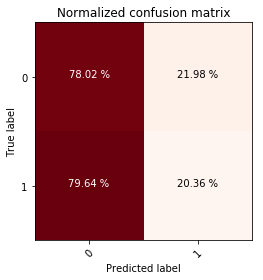

In [88]:
print('Общее число совпадений', accuracy_score(y_test, y_pred_2))
print('Полнота охвата класса 1:', recall_score(y_test, y_pred_2))
print('Точность:', precision_score(y_test, y_pred_2))
plot_confusion_matrix(y_test, y_pred_2, [0,1], normalize=True)

Что-то как-то лучше не стало...